# Phân cụm bài đăng mạng xã hội

## Import thư viện

In [18]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None) 
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Đọc data

In [19]:
df = pd.read_csv("Tweets.csv")
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


## Tiền xử lý dữ liệu

In [20]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text



df = df[['text']]
df['clean_text'] = df['text'].apply(clean_text)
df.head(15)

,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus youve added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,didnt today must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment guests faces amp little recourse
4,@VirginAmerica and it's a really big bad thing about it,really big bad thing
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay flight seats didnt playing really bad thing flying va
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",yes nearly every time fly vx ear worm wont go away
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",really missed prime opportunity men without hats parody
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",well didntbut
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",amazing arrived hour early youre good


## Biểu diễn văn bản thành TF-IDF

In [21]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    max_features=3000
)

X = vectorizer.fit_transform(df['clean_text'])
print(X.shape)


(14640, 2747)


# K-Means

## Xác định số cụm k

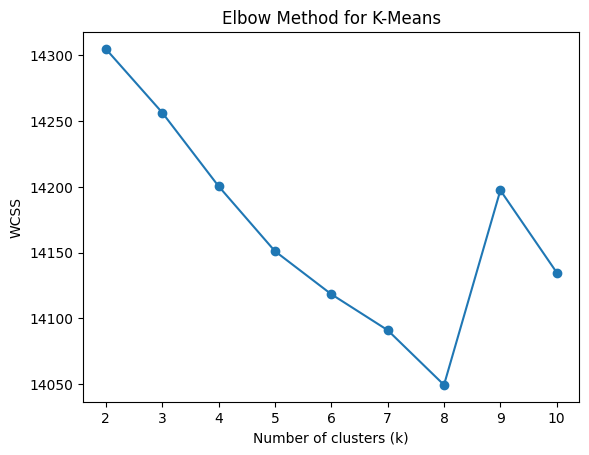

In [22]:
wcss = []

K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for K-Means")
plt.show()


## Chạy K-Means

In [23]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X)

df[['text','clean_text', 'kmeans_cluster']].head(20)


,text,clean_text,kmeans_cluster
0,@VirginAmerica What @dhepburn said.,said,0
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus youve added commercials experience tacky,0
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,didnt today must mean need take another trip,0
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment guests faces amp little recourse,2
4,@VirginAmerica and it's a really big bad thing about it,really big bad thing,0
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay flight seats didnt playing really bad thing flying va,4
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",yes nearly every time fly vx ear worm wont go away,2
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",really missed prime opportunity men without hats parody,0
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",well didntbut,0
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",amazing arrived hour early youre good,0


## Đánh giá Silhouette Score - K-Means

In [24]:
sil_kmeans = silhouette_score(X, df['kmeans_cluster'])
print("Silhouette Score (K-Means):", sil_kmeans)


Silhouette Score (K-Means): 0.006865969944342548


In [25]:
import pandas as pd
import numpy as np

terms = vectorizer.get_feature_names_out()

centroids = kmeans.cluster_centers_

top_n = 20

summary_kmeans = []

for cluster_id in range(k):
    cluster_size = (df['kmeans_cluster'] == cluster_id).sum()
    
    top_indices = centroids[cluster_id].argsort()[::-1][:top_n]
    top_keywords = ", ".join([terms[i] for i in top_indices])
    
    summary_kmeans.append({
        "Cluster": cluster_id,
        "Số bài đăng": cluster_size,
        "Top keywords": top_keywords
    })

df_kmeans_summary = pd.DataFrame(summary_kmeans)

for _, row in df_kmeans_summary.iterrows():
    print(f"\nCluster {row['Cluster']} ({row['Số bài đăng']} bài):")
    print(row['Top keywords'])



Cluster 0 (9506 bài):
thanks, thank, get, help, im, please, us, would, one, still, plane, hours, hold, dm, dont, flights, back, guys, like, bag

Cluster 1 (882 bài):
cancelled, flightled, flight, flighted, flights, hold, get, tomorrow, help, hours, rebook, today, dfw, need, got, one, weather, flighting, us, cant

Cluster 2 (1025 bài):
time, amp, flight, get, hold, im, first, got, call, back, us, still, flying, wait, last, plane, every, gate, thanks, fly

Cluster 3 (851 bài):
service, customer, worst, terrible, ever, great, call, thanks, hold, poor, phone, help, flight, line, thank, ive, care, rep, get, today

Cluster 4 (2376 bài):
flight, late, delayed, get, hours, hour, plane, gate, thanks, help, us, im, change, problems, cant, need, delay, booking, crew, tomorrow


# DBSCAN

## Cài đặt chỉ số

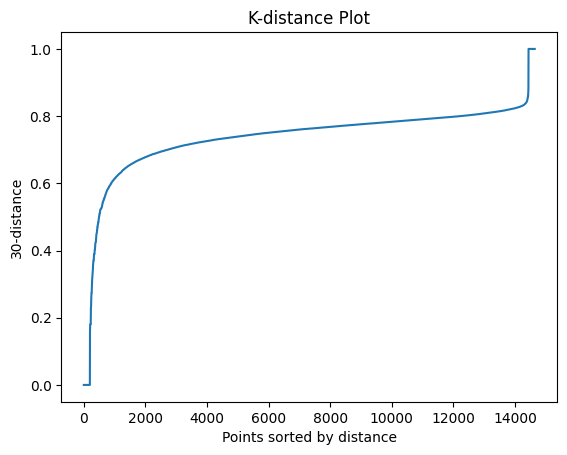

In [26]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 30

neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
neighbors_fit = neighbors.fit(X)

distances, indices = neighbors_fit.kneighbors(X)

k_distances = distances[:, k-1]

k_distances = np.sort(k_distances)

plt.figure()
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-distance")
plt.title("K-distance Plot")
plt.show()


In [27]:
dbscan = DBSCAN(eps=0.65, min_samples=30, metric='cosine')
df['dbscan_cluster'] = dbscan.fit_predict(X)
df['dbscan_cluster'].value_counts()

dbscan_cluster
 0     7623
-1     6828
 1       24
 7       24
 4       21
 6       19
 11      18
 8       17
 2       16
 10      16
 9       15
 3       11
 5        8
Name: count, dtype: int64

In [28]:
num_noise = (df['dbscan_cluster'] == -1).sum()
total = len(df)

print("Tổng số bài đăng:", total)
print("Nhiễu:", num_noise, " - ", round(num_noise / total * 100, 2), "%")

Tổng số bài đăng: 14640
Nhiễu: 6828  -  46.64 %


In [29]:
sil_dbscan = None

dbscan_labels = df['dbscan_cluster'].values  

if len(set(dbscan_labels)) > 2:
    mask = dbscan_labels != -1
    sil_dbscan = silhouette_score(X[mask],dbscan_labels[mask])
    print("Silhouette Score (DBSCAN):", sil_dbscan)
else:
    print("DBSCAN không tạo đủ cụm để tính Silhouette Score")


Silhouette Score (DBSCAN): -0.005300649235399514


In [30]:
result = pd.DataFrame({
    "Method": ["K-Means", "DBSCAN"],
    "Silhouette Score": [sil_kmeans, sil_dbscan]
})

result


,Method,Silhouette Score
0,K-Means,0.006866
1,DBSCAN,-0.005301


In [31]:
labels = df['dbscan_cluster'].values
terms = vectorizer.get_feature_names_out()

summary_dbscan = []
top_n = 15

for cluster_id in sorted(set(labels)):
    if cluster_id == -1:
        continue  # bỏ noise
    
    mask = labels == cluster_id
    cluster_size = mask.sum()
    
    mean_tfidf = X[mask].mean(axis=0)
    top_indices = mean_tfidf.A1.argsort()[::-1][:top_n]
    top_keywords = ", ".join([terms[i] for i in top_indices])
    
    summary_dbscan.append({
        "Cluster": cluster_id,
        "Số bài đăng": cluster_size,
        "Top keywords": top_keywords
    })

df_dbscan_summary = pd.DataFrame(summary_dbscan)
df_dbscan_summary

noise_count = (labels == -1).sum()
print("Noise:", noise_count, "/", len(labels))

for _, row in df_dbscan_summary.iterrows():
    print(f"\nDBSCAN Cluster {row['Cluster']} ({row['Số bài đăng']} bài):")
    print(row['Top keywords'])




Noise: 6828 / 14640

DBSCAN Cluster 0 (7623 bài):
flight, thanks, thank, cancelled, get, service, help, hold, customer, please, flightled, hours, dm, need, flights

DBSCAN Cluster 1 (24 bài):
sucks, service, totally, ual, literally, stuck, dont, customer, houston, see, florida, merged, flights, though, learn

DBSCAN Cluster 2 (16 bài):
mean, near, yeah, stuff, almost, ktn, sitting, care, inappropriate, interview, one, survey, gate, pre, assaulted

DBSCAN Cluster 3 (11 bài):
link, mobile, work, isnt, confused, dont, via, directed, email, failing, initial, ipad, didnt, flight, cancelled

DBSCAN Cluster 4 (21 bài):
th, marks, january, feb, birthday, aa, anniversary, space, job, la, plane, could, police, check, got

DBSCAN Cluster 5 (8 bài):
look, forward, hearing, trip, mad, statement, damn, train, must, soon, tv, seems, old, though, card

DBSCAN Cluster 6 (19 bài):
scheduled, departure, flight, time, plane, sitting, depart, leave, still, make, mins, pm, lga, canada, sky

DBSCAN Cluster 7